# 
RLCT Estimation of Sorting

This Jupyter Notebook aims to measure the Real Log Canonical Threshold (RLCT) for a small 3-layer transformer model (~280,000 parameters) trained to sort sequences of 20 digits consisting of the numbers 0-19. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Generate the dataset of numbers to sort.
2. **Model Training**: Train a transformer model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [1]:
import itertools
from tqdm.notebook import tqdm
import numpy as np
from math import comb
import torch

def generate_combinations(n, k):
    """
    Generate all combinations of n choose k, excluding specific combinations.
    
    Parameters:
    n (int): Total number of items.
    k (int): Number of items to choose.
    exclude_set (set of tuples): Combinations to exclude.
    
    Yields:
    tuple: The next valid combination.
    """
    def comb_descending(combination):
        return all(combination[i] >= combination[i + 1] for i in range(len(combination) - 1))
        
    for combination in tqdm(itertools.combinations(range(n - 1, 0, -1), k)):
        #if comb_descending(combination):
        yield combination

def swap(arr, idx, jdx):
    temp = arr[idx]
    arr[idx] = arr[jdx]
    arr[jdx] = temp

def create_sequence(arr, indices):
    new_arr = arr.copy()
    for idx in indices:
        swap(new_arr, idx, idx - 1)
    return new_arr

def create_sequences(arr, combinations):
    sequences = []
    for combination in combinations:
        sequences.append(create_sequence(arr, list(combination)))
    return sequences

def apply_swaps(arr, num_swaps):
    for idx in range(len(arr) - 1):
        if arr[idx] > arr[idx + 1]:
            temp = arr[idx]
            arr[idx] = arr[idx + 1]
            arr[idx + 1] = temp
            num_swaps -= 1
        if num_swaps == 0:
            return arr, True
    return arr, False

def count_inversions(arr):
    """
    Count the number of inversions (adjacent swaps) needed to sort the array.

    Parameters:
    arr (list): List of integers to count inversions in.

    Returns:
    int: Number of inversions.
    """
    if len(arr) < 2:
        return 0

    mid = len(arr) // 2
    left = arr[:mid]
    right = arr[mid:]

    inversions = count_inversions(left) + count_inversions(right)
    #inversions = count_inversions(left)

    i = j = k = 0
    while i < len(left) and j < len(right):
        if left[i] <= right[j]:
            arr[k] = left[i]
            i += 1
        else:
            arr[k] = right[j]
            inversions += len(left) - i
            j += 1
        k += 1

    while i < len(left):
        arr[k] = left[i]
        i += 1
        k += 1

    while j < len(right):
        arr[k] = right[j]
        j += 1
        k += 1

    return inversions
'''
# Print permutations

print(type(all_permutations[0]), all_permutations[0])
num_swaps = 2
num_valid = 0
num_invalid = 0
for perm in tqdm(all_permutations):
    seq = [*perm]
    
    if count_inversions(seq) == num_swaps:
        swapped_seq, res = apply_swaps([*perm], num_swaps)
        if res:
            print('Valid: ', perm)
            print("Number of adjacent swaps needed:", num_swaps)
            num_valid += 1
        else:
            print("Non-valid: ", perm)
            print("Number of adjacent swaps needed:", num_swaps)
            num_invalid += 1

print(num_valid, num_invalid)
'''

from itertools import combinations
from functools import partial

def prepare_bubble_sort_dataset(sequence, lower, upper, train=True):
    n = len(sequence)
    num_seq = sum((lambda n, k : comb(n - 1, k))(n, k) for k in range(lower, upper))
    sequences = torch.zeros(num_seq, n)
    curr_idx = 0
    for idx in range(lower, upper):
        print(comb(n - 1, idx))
        combs = combinations(range(n - 1, 0, -1), idx)
        #if train:
        #    combs = combinations(range(n - 1, 0, -1), idx)
        #else:
        #    combs = combinations(range(1, n, 1), idx)
        test = torch.tensor(create_sequences(sequence, combs))
        sequences[curr_idx : curr_idx + comb(n - 1, idx), : ] = test
        curr_idx += comb(n - 1, idx)
    return sequences.long()

In [2]:
%pip install devinterp seaborn torchvision pickleshare transformer_lens pytest
!git clone https://github.com/ucla-vision/entropy-sgd.git
%cd entropy-sgd
from python.optim import EntropySGD  
%cd ..

Note: you may need to restart the kernel to use updated packages.
fatal: destination path 'entropy-sgd' already exists and is not an empty directory.
/Users/ben/Documents/MSc Project/DevInterp/sortinterp/entropy-sgd
/Users/ben/Documents/MSc Project/DevInterp/sortinterp


In [3]:
from transformer_lens import HookedTransformerConfig, HookedTransformer
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from python.optim import EntropySGD

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

PRIMARY, SECONDARY, TERTIARY, QUATERNARY = sns.color_palette("muted")[:4]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT, QUATERNARY_LIGHT = sns.color_palette(
    "pastel"
)[:4]

input_size = 20 # Length of sequences
vocab_size = 20 # Vocabulary size

n_heads = 12
n_layers = 6
d_head = vocab_size + 2
d_mlp = input_size * vocab_size
d_mlp = 420
# Activation function is a GeLu, this the standard activation for tracr as far as I can tell
act_fn = "relu"
normalization_type = "LN"
attention_type = "bidirectional"

n_ctx = vocab_size + 1
# Equivalent to length of vocab, with BOS and PAD at the end
d_vocab = vocab_size + 2
# Residual stream width, I don't know of an easy way to infer it from the above config.
#d_model = 5 + 2 * input_size + 3 * vocab_size
d_model = 105

# Equivalent to length of vocab, WITHOUT BOS and PAD at the end because we never care about
# these outputs. In practice, we always feed the logits into an argmax
d_vocab_out = vocab_size

cfg = HookedTransformerConfig(
    n_layers=n_layers,
    d_model=d_model,
    d_head=d_head,
    n_ctx=n_ctx,
    d_vocab=d_vocab,
    d_vocab_out=d_vocab_out,
    d_mlp=d_mlp,
    n_heads=n_heads,
    act_fn=act_fn,
    attention_dir=attention_type,
    normalization_type=normalization_type,
)
print(cfg)

RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.

In [42]:
def remove_common_rows(tensor_a, tensor_b):
    """
    Remove rows from tensor_a that appear in tensor_b.

    :param tensor_a: The original tensor from which to remove rows
    :param tensor_b: The tensor containing rows to be removed from tensor_a
    :return: A tensor with the rows removed
    """
    # Convert tensor_b to a set of tuples for efficient lookups
    tensor_b_set = set(tuple(row.tolist()) for row in tensor_b)

    # Filter tensor_a by checking if each row is in the tensor_b_set
    filtered_rows = [row for row in tqdm(tensor_a) if tuple(row.tolist()) not in tensor_b_set]

    # Convert the list of filtered rows back to a tensor
    filtered_tensor = torch.stack(filtered_rows)

    return filtered_tensor

# this dataset is intended as a control
def get_dataset_0(input_size, vocab_size):
    # generate random sequences of size input_size using numbers between 0 and vocab_size
    sequences = torch.randint(0, vocab_size, (2 * (input_size * (vocab_size - 2) + 1), input_size))
    
    # split into train and test
    split = int(0.25 * len(sequences))
    train_sequences = sequences[ : split]
    test_sequences = sequences[split : ]
    return train_sequences, test_sequences

# this dataset is intended to incentivise the model to learn a simpler algorithm than sorting, 
# namely putting the nonzero number at the end
def get_dataset_1(input_size, vocab_size):
    # construct all sequences that consist entirely of zeros except for one non-zero element 
    # which will be a number between 1 and vocab_size - 1
    sequences = torch.eye(input_size).unsqueeze(dim=0) * torch.arange(1, vocab_size // 2).reshape(-1, 1, 1)
    # include all zeros sequence
    train_sequences = torch.cat((torch.zeros(1, sequences.size(dim=1)), sequences.reshape(-1, input_size)), dim=0).long()
    
    # test sequences are sequences containing any of the digits from 0 to vocab_size
    #test_sequences = torch.randint(1, vocab_size, ((input_size * (vocab_size - 2) + 1) // 2, input_size))
    test_sequences = (torch.eye(input_size).unsqueeze(dim=0) * torch.arange(vocab_size // 2, vocab_size - 1).reshape(-1, 1, 1)).reshape(-1, input_size).long()
    shifted_matrix = torch.zeros_like(test_sequences)
    shifted_matrix[:, :-10] = test_sequences[:, 10:]
    test_sequences = shifted_matrix + train_sequences[1 : ]
    print(test_sequences)
    rand_sequences = torch.randint(1, vocab_size, ((input_size * (vocab_size - 2) + 1), input_size))
    
    # ensure that we remove possible training elements
    #test_sequences = remove_common_rows(test_sequences, train_sequences)
    
    # include a small amount of the `correct' signal in the training data
    # so that the model can still potentially learn the correct algorithm
    split = int(0.05 * len(train_sequences))
    print(split)
    train_sequences = torch.cat((train_sequences, rand_sequences[ : split]), dim=0)
    test_sequences = torch.cat((test_sequences, rand_sequences[split : ]), dim=0)
    return train_sequences, test_sequences

# this dataset is intendent to incentivise the model to learn a sorting algorithm specific to certain digits only
def get_dataset_2(input_size, vocab_size):
    # ensure that training sequences consist of primarily of sequences containing numbers from 0 to middle
    middle = vocab_size // 2
    train_sequences = torch.randint(0, middle, ((input_size * (vocab_size - 3) + 1) // 2, input_size))
    
    # test sequences consist of sequences containing numbers from middle to vocab_size -1
    test_sequences = torch.randint(middle, vocab_size, (int(1.5 * (input_size * (vocab_size - 2) + 1)), input_size))
    
    # include a small amount of the `correct' signal in the training data
    # so that the model can still potentially learn the correct algorithm
    split = int(0.01 * len(train_sequences))
    train_sequences = torch.cat((train_sequences, test_sequences[ : split]), dim=0)
    test_sequences = test_sequences[split : ]
    return train_sequences, test_sequences

def get_dataset_3(input_size, vocab_size):
    # ensure that training sequences consist of primarily of sequences containing numbers from 0 to middle
    train_sequences = prepare_bubble_sort_dataset(list(range(vocab_size)), 0, vocab_size - 13)
    extra_train_sequences = prepare_bubble_sort_dataset(list(range(vocab_size - 1, -1, -1)), 0, vocab_size - 13)
    extra_train_sequences = remove_common_rows(extra_train_sequences, train_sequences)
    sequences = prepare_bubble_sort_dataset(list(range(vocab_size - 1)), 0, vocab_size - 13)
    with_duplicates_train_sequences = torch.cat([sequences, torch.randint(0, vocab_size, (len(sequences), 1))], dim=1)
    #print('dup: ', with_duplicates_train_sequences[0 : 10])
    train_sequences = torch.cat([train_sequences, extra_train_sequences], dim=0)
    train_sequences = torch.cat([train_sequences, with_duplicates_train_sequences], dim=0)
    random_indices = torch.randperm(train_sequences.size(0))[ : len(train_sequences) // 2]

    # Select the random subset of rows
    train_sequences = train_sequences[random_indices]
    print(train_sequences.shape)
    
    # test sequences consist of sequences containing numbers from middle to vocab_size -1
    test_sequences = torch.randint(0, vocab_size, (len(train_sequences) // 4, input_size))
    #test_sequences = prepare_bubble_sort_dataset(vocab_size, 0, 3, False)[ : len(train_sequences)]
    print(test_sequences.shape)
    test_sequences = remove_common_rows(test_sequences, train_sequences)
    print(test_sequences[0 : 10])
    
    # include a small amount of the `correct' signal in the training data
    # so that the model can still potentially learn the correct algorithm
    split = int(0.005 * len(train_sequences))
    print('num sequences to be added to training: ', split)
    train_sequences = torch.cat([train_sequences, test_sequences[ : split]], dim=0)
    test_sequences = test_sequences[split : ]
    return train_sequences, test_sequences
    

def get_data(input_size, vocab_size, dataset=1):
    if dataset == 0:
        train_sequences, test_sequences = get_dataset_0(input_size, vocab_size)
    elif dataset == 1:
        train_sequences, test_sequences = get_dataset_1(input_size, vocab_size)
    elif dataset == 2:
        train_sequences, test_sequences = get_dataset_2(input_size, vocab_size)
    elif dataset == 3:
        train_sequences, test_sequences = get_dataset_3(input_size, vocab_size)
    else:
        print('enter a dataset number between 0 and 2')
        
    train_sequences_sorted = torch.sort(train_sequences, dim=1).values
    test_sequences_sorted = torch.sort(test_sequences, dim=1).values
    train_data = list(zip(train_sequences, train_sequences_sorted))
    test_data = list(zip(test_sequences,  test_sequences_sorted))
    return train_data, test_data

dataset = 3
train_data, test_data = get_data(input_size, vocab_size, dataset)
train_size = len(train_data)
test_size = len(test_data)
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

1
19
171
969
3876
11628
27132
1
19
171
969
3876
11628
27132


  0%|          | 0/43796 [00:00<?, ?it/s]

1
18
153
816
3060
8568
18564
torch.Size([59386, 20])
torch.Size([14846, 20])


  0%|          | 0/14846 [00:00<?, ?it/s]

tensor([[14,  9, 17, 11, 10,  1,  3, 11,  9, 19,  0, 18,  4,  3,  6,  2, 14, 10,
          4,  0],
        [13, 11,  6,  9,  3,  6,  0, 12, 12,  0,  5, 15,  2, 15, 18,  6,  7,  8,
          7,  1],
        [14, 14, 17, 15,  0,  2, 11,  2,  5,  4, 10,  7, 10, 13, 13,  4, 11,  7,
         17, 11],
        [18, 19, 15, 19,  8,  0, 11, 11,  5,  1,  1, 13, 10,  9, 11,  7, 15,  0,
         10,  6],
        [ 0, 18, 15, 14,  4,  3, 13, 16,  8,  3,  7, 13, 14,  7, 17,  0,  9,  8,
         10,  0],
        [ 5,  2,  6, 13, 11, 13,  1,  1, 18, 10,  0,  9, 18, 10,  9,  1, 18, 13,
         13, 11],
        [16, 18,  7,  9, 19, 13, 16,  1, 16, 11,  1,  4, 13, 15,  9,  1,  0,  0,
         14, 19],
        [ 3,  9,  8, 18,  2,  6, 15, 14,  5, 18, 10, 11, 11,  7,  0,  8,  6, 18,
         17, 13],
        [ 7, 10, 11, 11,  5,  7, 18,  0,  9,  7, 17, 12,  5,  2,  1,  5, 13,  0,
         14,  8],
        [ 7,  8, 17,  7, 17, 18,  6,  1, 16, 12, 11, 16, 12,  9,  5, 15,  9,  0,
          2, 17]])
num seque

In [43]:
def accuracy_function(outputs, targets):
    return (outputs.argmax(1) == targets).float().mean()

def train_one_epoch(model, train_loader, optimizer, criterion, model_key):
    model.train()
    train_loss = 0
    train_accuracy = 0 
    for index, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data.to(DEVICE))
        outputs = outputs.permute(0, 2, 1)
        loss = criterion(outputs, targets.to(DEVICE))
        train_loss += loss.item()
        train_accuracy += accuracy_function(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()
        
    return train_loss / len(train_loader), train_accuracy / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for index, (data, targets) in enumerate(test_loader):
            outputs = model(data.to(DEVICE))
            outputs = outputs.permute(0, 2, 1)
            loss = criterion(outputs, targets.to(DEVICE))
            test_loss += loss.item()
            test_accuracy += accuracy_function(outputs, targets.to(DEVICE))
            
    return test_loss / len(test_loader), test_accuracy / len(test_loader)

class CustomTransformerBlock(torch.nn.Module):
    def __init__(self, config):
        super(CustomTransformerBlock, self).__init__()
        self.attention = HookedTransformerAttention(config)

    def forward(self, x, *args, **kwargs):
        x = self.attention(x, *args, **kwargs)
        return x

class CustomTransformer(HookedTransformer):
    def __init__(self, config):
        super(CustomTransformer, self).__init__(config)
        self.blocks = torch.nn.ModuleList([
            CustomTransformerBlock(config) for _ in range(config.n_layers)
        ])


In [44]:
# Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512
LR = 1e-4
N_EPOCHS = 100

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [45]:
def train_models(train_loader, test_loader, criterion, runs):
    train_losses = torch.zeros(runs, N_EPOCHS)
    test_losses = torch.zeros(runs, N_EPOCHS)
    train_accuracies = torch.zeros(runs, N_EPOCHS)
    test_accuracies = torch.zeros(runs, N_EPOCHS)
    models_saved = []
    for run in tqdm(range(runs)):
        model = HookedTransformer(cfg)
        #print(sum(p.numel() for p in model.parameters() if p.requires_grad))
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        for epoch in tqdm(range(N_EPOCHS)):
            train_loss, train_accuracy = train_one_epoch(
                model, train_loader, optimizer, criterion, 'sgd'
            )
            test_loss, test_accuracy = evaluate(model, test_loader, criterion)
            train_losses[run, epoch] = train_loss
            test_losses[run, epoch] = test_loss
            train_accuracies[run, epoch] = train_accuracy
            test_accuracies[run, epoch] = test_accuracy
            models_saved += [copy.deepcopy(model)]
            print(
                f"Epoch {epoch+1}, Model {'sgd'.upper()} Train Loss: {train_loss}, Test Loss: {test_loss}", '\n',
                f"Epoch {epoch+1}, Model {'sgd'.upper()} Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}"
            )
        
    train_losses_final = train_losses.mean(dim=0)
    test_losses_final = test_losses.mean(dim=0)
    train_accuracies_final = train_accuracies.mean(dim=0)
    test_accuracies_final = test_accuracies.mean(dim=0)
    return train_losses_final, test_losses_final, train_accuracies_final, test_accuracies_final, models_saved

runs = 1
train_losses_final, test_losses_final, train_accuracies_final, test_accuracies_final, models_saved = train_models(train_loader, test_loader, criterion, runs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Model SGD Train Loss: 0.9406833331554364, Test Loss: 2.845904769568608 
 Epoch 1, Model SGD Train Accuracy: 0.7739173173904419, Test Accuracy: 0.24237215518951416
Epoch 2, Model SGD Train Loss: 0.08409554985725981, Test Loss: 2.70182912103061 
 Epoch 2, Model SGD Train Accuracy: 0.9843102097511292, Test Accuracy: 0.2763229310512543
Epoch 3, Model SGD Train Loss: 0.032752781198957026, Test Loss: 2.6005144448115907 
 Epoch 3, Model SGD Train Accuracy: 0.9960846304893494, Test Accuracy: 0.2950640916824341
Epoch 4, Model SGD Train Loss: 0.02240768091705365, Test Loss: 2.479066980296168 
 Epoch 4, Model SGD Train Accuracy: 0.9965329766273499, Test Accuracy: 0.30986082553863525
Epoch 5, Model SGD Train Loss: 0.018357085195393898, Test Loss: 2.364522753090694 
 Epoch 5, Model SGD Train Accuracy: 0.9966422915458679, Test Accuracy: 0.3239506781101227
Epoch 6, Model SGD Train Loss: 0.01597892623155927, Test Loss: 2.26181802256354 
 Epoch 6, Model SGD Train Accuracy: 0.9967390298843384, 

In [48]:
from devinterp.slt import estimate_learning_coeff_with_summary



def estimate_rlcts(models, train_loader, criterion, data_length, device, num_draws):
    estimates = {"sgnht": [], "sgld": []}
    for idx, model in enumerate(tqdm(models)):
        for method, optimizer_kwargs in [
            #("sgnht", {"lr": 1e-7, "diffusion_factor": 0.01}),
            ("sgld", {"lr": 1e-3, "localization": 100.0, "noise_level": 1.0}),
        ]:
            results = estimate_learning_coeff_with_summary(
                model,
                train_loader,
                criterion=criterion,
                optimizer_kwargs=optimizer_kwargs,
                sampling_method=SGNHT if method == "sgnht" else SGLD,
                num_chains=1,
                num_draws=num_draws,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=device,
                seed=42
            )
            estimate = results["llc/mean"]
            
            # take losses from last chain for plotting
            if idx == N_EPOCHS - 1:
                losses = results['loss/trace']
            estimates[method].append(estimate)
    return estimates, losses

def obtain_rlct_estimates(train_loader, models_saved, criterion, runs):
    data_length = len(train_loader.dataset)
    rlct_estimates = {"sgnht": torch.zeros(runs, N_EPOCHS), "sgld": torch.zeros(runs, N_EPOCHS)}
    num_draws = 400
    last_chain_losses = torch.zeros(runs, num_draws)

    for run in tqdm(range(runs)):
        rlct_estimate, losses = estimate_rlcts(
            models_saved[N_EPOCHS * run : N_EPOCHS * (run + 1)], train_loader, criterion, data_length, DEVICE, num_draws
        )
        #rlct_estimates["sgnht"][run] = torch.tensor(rlct_estimate["sgnht"])
        rlct_estimates["sgld"][run] = torch.tensor(rlct_estimate["sgld"])
        last_chain_losses[run] = torch.tensor(losses)

    rlct_estimates_final = {"sgnht": rlct_estimates["sgnht"].mean(dim=0), "sgld": rlct_estimates["sgld"].mean(dim=0)}
    return rlct_estimates_final, last_chain_losses.mean(dim=0)

rlct_estimates_final, last_chain_losses_final = obtain_rlct_estimates(train_loader, models_saved, criterion, runs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.63it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 19.10it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:22, 17.60it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:22, 17.52it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 17.73it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:22, 17.47it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:22, 17.25it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:22, 17.31it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:22, 17.97it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:23, 16.99it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:21, 18.60it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.72it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.47it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:21, 17.74it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:19, 19.99it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:19, 19.94it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 19.92it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:19, 19.78it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.38it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.94it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.84it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.47it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.10it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.83it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.43it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.00it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:21, 18.18it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:20, 19.00it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.32it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 19.18it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.17it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.16it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.17it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.59it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.38it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:20, 19.50it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:21, 18.56it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:21, 18.56it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:21, 18.38it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:21, 18.30it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 18.16it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.70it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.72it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.62it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.39it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.12it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.66it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.23it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.39it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.86it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.67it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.48it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 20.30it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:18, 20.28it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:18, 20.27it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:01<00:19, 19.71it/s]

Chain 0:   6%|████▏   

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:24, 16.55it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:21, 18.05it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:22, 17.88it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.56it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.82it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.35it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 19.11it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.22it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.41it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.19it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.12it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.02it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.56it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.69it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.23it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.02it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.60it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.76it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.79it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 19.09it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:20, 18.73it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.44it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.23it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 18.84it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.00it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 17.95it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.80it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:21, 18.10it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:23, 17.11it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:21, 18.45it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 18.97it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 18.89it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:21, 18.51it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 18.27it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 19.09it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.31it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.31it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.66it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 19.47it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.78it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.81it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.73it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.23it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.19it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.51it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 19.62it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.04it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.46it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.89it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.47it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.58it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.40it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.87it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.15it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.41it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.60it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.63it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 18.79it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.64it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.36it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.12it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.73it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 19.06it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.30it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.05it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.63it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.36it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.24it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 18.19it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.71it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.38it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.36it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.56it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 19.80it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.29it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.89it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.40it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:22, 17.55it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 18.90it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.28it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.28it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.05it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 19.01it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:21, 18.57it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:21, 18.70it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.08it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 18.70it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:21, 18.40it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 19.18it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.30it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.74it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 20.25it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:19, 20.15it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 20.09it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 20.14it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.60it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:19, 19.07it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:19, 19.94it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:21, 18.48it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.14it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.41it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.22it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.75it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.98it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:19, 19.99it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:22, 17.62it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:22, 17.63it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:22, 17.53it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.23it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.68it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 19.03it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.61it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 19.32it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.68it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.53it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.07it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.61it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.52it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:19, 19.94it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 18.90it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.40it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.10it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.08it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.98it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.46it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:23, 16.78it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:20, 19.00it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.24it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 18.73it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.93it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.43it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.08it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 18.77it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.92it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.65it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.32it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.71it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.92it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.95it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 19.30it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.58it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.67it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.99it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.60it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.89it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:19, 20.00it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:19, 19.98it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.52it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:19, 19.63it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.74it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.10it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 19.16it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.30it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.63it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.87it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.15it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.77it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.90it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:21, 17.91it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:22, 17.90it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 18.89it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.21it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.08it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.41it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.89it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 19.22it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:21, 18.47it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:21, 18.55it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:21, 17.91it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:21, 18.54it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.80it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.15it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.84it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.73it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 19.13it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.42it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.87it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.16it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.42it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.56it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.40it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.17it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.10it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.44it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.55it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.64it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:20, 19.09it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.47it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.43it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.74it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.01it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.60it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.99it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.70it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.68it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:20, 19.29it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:21, 18.54it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 18.82it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.10it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.32it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.43it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.61it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.63it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.80it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 20.07it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 19.14it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.49it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:19, 19.55it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.53it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:22, 17.85it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.22it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.08it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.06it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.54it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.94it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.63it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.20it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.92it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.76it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.59it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.84it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.71it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.36it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:20, 19.51it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.35it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.41it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.45it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 18.36it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 19.14it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.60it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.06it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:21, 18.49it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.58it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 19.25it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.54it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:20, 18.71it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.63it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 19.72it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.43it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.17it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.55it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.31it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 19.11it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:22, 17.85it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:20, 19.67it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.49it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:19, 19.68it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.74it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 19.02it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.85it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.67it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.66it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:18, 20.58it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.96it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.52it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:19, 19.83it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.15it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.40it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:22, 17.59it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.60it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.54it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.77it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:01<00:19, 19.17it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.62it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 19.96it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.45it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:19, 19.86it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.48it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.86it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 20.04it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:20, 19.54it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:21, 18.56it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:22, 17.62it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:21, 17.83it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:22, 17.33it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 17.71it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:21, 17.80it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.77it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.30it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.28it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.82it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 19.14it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.84it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:20, 18.70it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.66it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:19, 19.84it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 18.99it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.65it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.72it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.47it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.38it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.30it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.53it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.90it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.90it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.42it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.72it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:19, 19.08it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.72it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.63it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:22, 17.62it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:22, 17.67it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:22, 17.08it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:22, 17.45it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:21, 17.58it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:21, 18.69it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:21, 18.34it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.76it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.00it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.02it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.45it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.79it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.43it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 19.89it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:19, 19.78it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:19, 19.79it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.36it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.47it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.75it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.61it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 19.84it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:19, 20.11it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 19.95it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:19, 19.50it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.46it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.20it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.66it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.63it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.96it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.73it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.64it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.77it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.62it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.35it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.27it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.14it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 20.11it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 20.02it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 20.05it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:01<00:18, 19.95it/s]

Chain 0:   6%|████▍   

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.71it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.55it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.93it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.21it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.16it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.34it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.51it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:24, 16.37it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:22, 17.95it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.19it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.73it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.02it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.16it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.62it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.77it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 18.89it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.53it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.09it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.15it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.38it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.60it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.44it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.44it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.07it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.55it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.51it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.86it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:18, 20.02it/s]

Chain 0:   6%|████▏   

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.64it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.45it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.47it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 20.42it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.74it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.48it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:19, 19.58it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.55it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.58it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.30it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.72it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.43it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 19.00it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:19, 19.37it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.57it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.38it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.18it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 20.18it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.46it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.81it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:20, 18.41it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.91it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 19.80it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:19, 19.84it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:19, 20.00it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.99it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.42it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.82it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.71it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 19.76it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.02it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.96it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.45it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.51it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:19, 19.09it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.32it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 20.05it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:19, 19.99it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.96it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.31it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.76it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.35it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.43it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.50it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.72it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 19.80it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:19, 19.73it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.84it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.47it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:21, 18.38it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:22, 17.28it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 18.95it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.25it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.28it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.33it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.24it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 20.05it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.55it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.65it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.35it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:19, 19.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.64it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.34it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.26it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.67it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.34it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:19, 19.40it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.98it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.53it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.62it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.42it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.04it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.54it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.75it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:19, 19.17it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.57it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.49it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.36it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.23it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.87it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.41it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:19, 19.74it/s]

Chain 0:   6%|████▏   

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.56it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.64it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.09it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.04it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 18.41it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.74it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 19.08it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.70it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:22, 17.71it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:21, 18.19it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.95it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.42it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.55it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:19, 19.16it/s]

Chain 0:   5%|███▊    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.58it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.39it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.01it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 19.59it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 17.73it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:21, 17.73it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:21, 17.73it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.54it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.26it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.81it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.54it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.34it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 17.97it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.88it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.19it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.53it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.27it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:22, 17.65it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.80it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:21, 17.89it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:21, 17.96it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.38it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.00it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 18.82it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.65it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 18.34it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.35it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.28it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:19, 19.92it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 20.22it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.60it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:19, 19.90it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 19.31it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.97it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 19.06it/s]

Chain 0:   5%|███▍    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.46it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.05it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 20.23it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 20.08it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.50it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:19, 19.15it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:19, 19.58it/s]

Chain 0:   6%|████▏   

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.76it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.59it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:18, 20.62it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.75it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 20.01it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.82it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:19, 19.86it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.53it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.56it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:19, 19.85it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 20.02it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 20.00it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.59it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:01<00:20, 18.56it/s]

Chain 0:   6%|████▏   

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.34it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 20.08it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.01it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:21, 18.04it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 18.00it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.37it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:01<00:19, 19.07it/s]

Chain 0:   6%|████    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.55it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.56it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.04it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 17.86it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 18.35it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 18.59it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:20, 18.45it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.50it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:19, 19.81it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.28it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 18.69it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 18.92it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:20, 18.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:21, 17.98it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.26it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.33it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.98it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.36it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.61it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:19, 19.33it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:20, 18.49it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.45it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 20.12it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:19, 19.95it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.36it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:19, 19.42it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:19, 19.25it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:19, 19.64it/s]

Chain 0:   5%|███▋    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.65it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.61it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.28it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.34it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.28it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 18.25it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:21, 18.25it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:21, 18.39it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:20, 18.98it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.24it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 18.78it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 19.17it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.66it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:21, 18.06it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.88it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:19, 20.06it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 18.95it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.08it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:20, 19.22it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:19, 19.43it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.92it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.28it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.36it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:22, 17.42it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:22, 17.59it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:22, 17.62it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 18.23it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:20, 18.73it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.74it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:23, 16.75it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:22, 17.73it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:22, 17.77it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 17.82it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 17.88it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 17.73it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<00:19, 20.08it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.22it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:20, 19.29it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:21, 18.57it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.41it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 17.67it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:21, 17.57it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.74it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 19.14it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 19.43it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:19, 19.60it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:20, 19.01it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 18.01it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:22, 17.45it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.02it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 19.43it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:20, 18.79it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:20, 19.54it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:21, 18.47it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:21, 18.27it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:21, 18.23it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.04it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:20, 19.68it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:20, 19.02it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:21, 18.04it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:21, 17.69it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 18.11it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:21, 18.08it/s]

Chain 0:   4%|███▎    

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:22, 17.57it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:20, 18.87it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:21, 18.30it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:21, 18.09it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:20, 18.83it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:20, 18.86it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:20, 19.02it/s]

Chain 0:   4%|███     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:22, 17.66it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:21, 18.84it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:22, 17.65it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:22, 17.70it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:22, 17.66it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:22, 17.60it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 17.59it/s]

Chain 0:   4%|██▉     

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<00:20, 19.88it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<00:19, 19.83it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:23, 16.89it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:22, 17.15it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:22, 17.28it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:21, 17.96it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:21, 17.75it/s]

Chain 0:   4%|███     

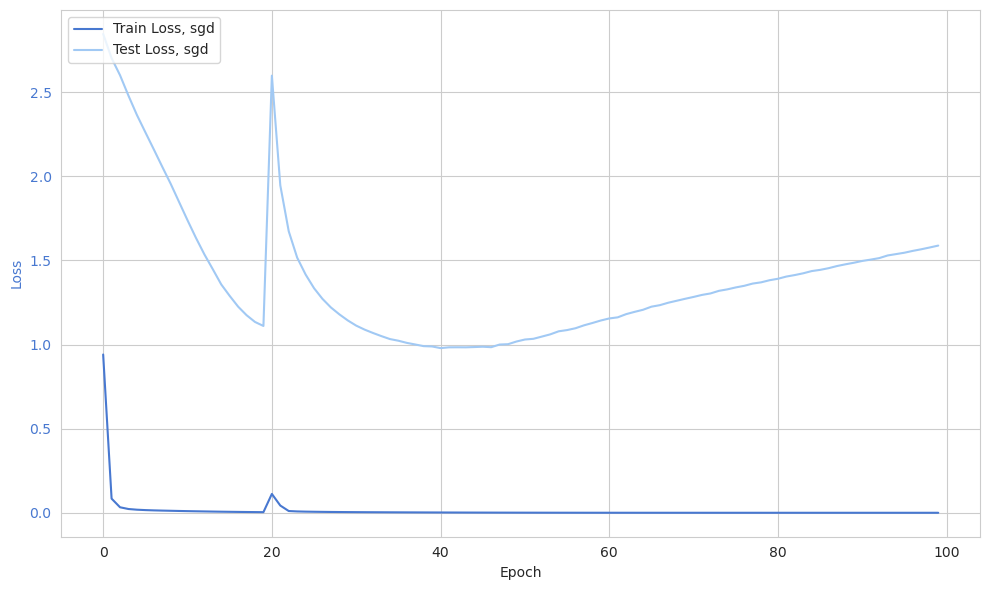

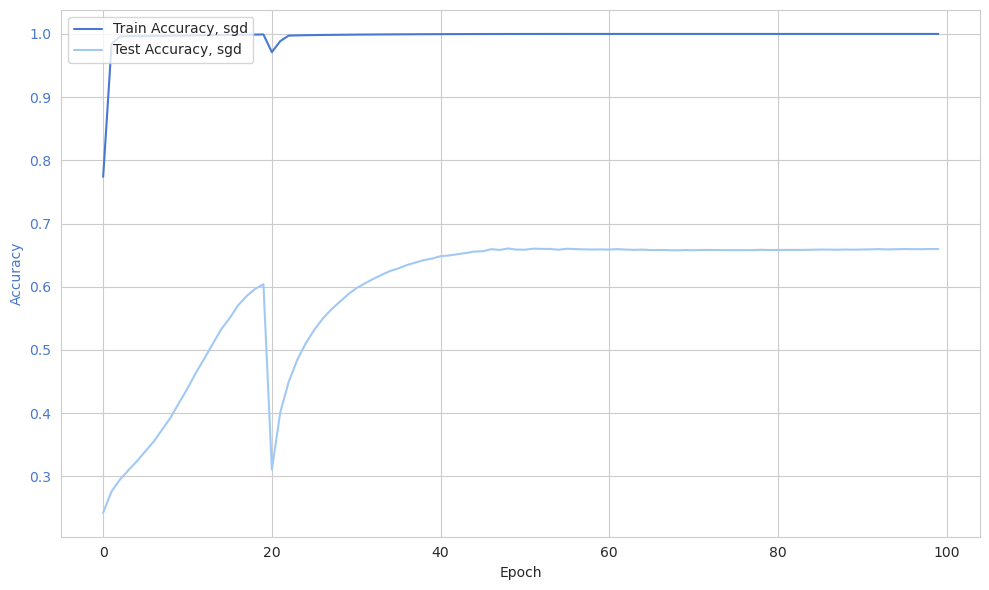

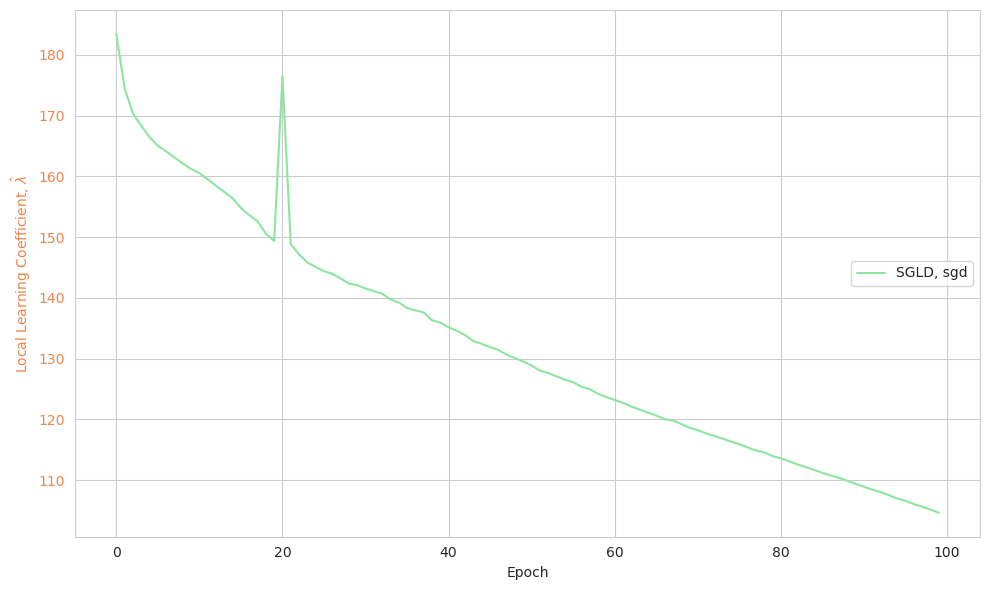

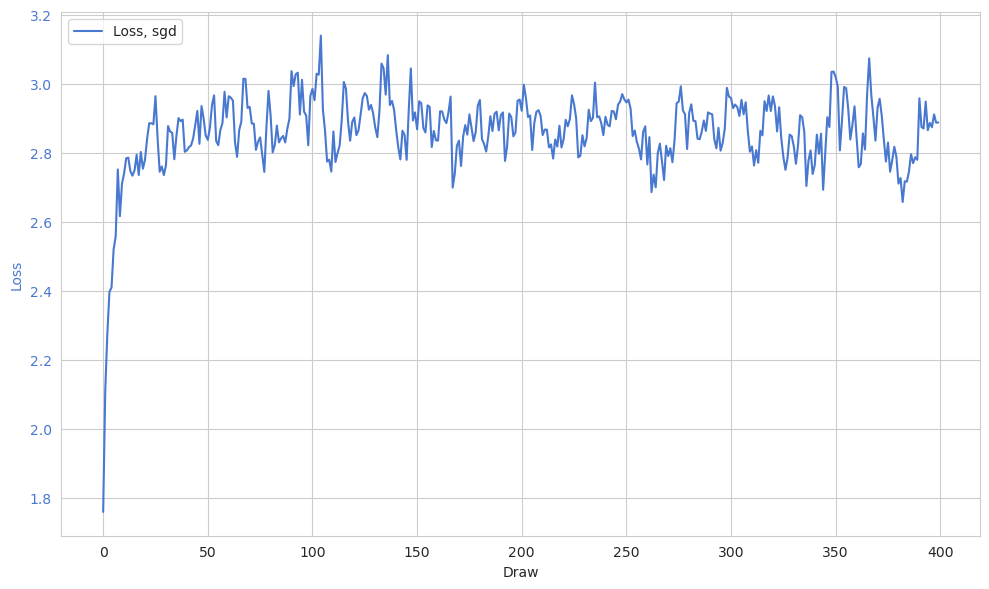

In [49]:
def plot_losses(train_losses_final, test_losses_final, dataset):
    
    sns.set_style("whitegrid")
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(train_losses_final, label="Train Loss, sgd", color=PRIMARY)
    ax1.plot(test_losses_final, label="Test Loss, sgd", color=PRIMARY_LIGHT)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.show()
    fig.savefig("losses_" + str(dataset) + "_" + str(N_EPOCHS) + "_epochs.png")

def plot_accuracies(train_accuracies_final, test_accuracies_final, dataset):
    
    sns.set_style("whitegrid")
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy", color=PRIMARY)
    ax1.plot(train_accuracies_final, label="Train Accuracy, sgd", color=PRIMARY)
    ax1.plot(test_accuracies_final, label="Test Accuracy, sgd", color=PRIMARY_LIGHT)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.show()
    fig.savefig("accuracies_" + str(dataset) + "_" + str(N_EPOCHS) + "_epochs.png")

def plot_rclts(rlct_estimates_final, dataset):
    
    sns.set_style("whitegrid")

    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    #ax2.plot(rlct_estimates_final["sgnht"], label="SGNHT, sgd", color=TERTIARY)
    ax2.plot(rlct_estimates_final["sgld"], label="SGLD, sgd", color=TERTIARY_LIGHT)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")

    fig.tight_layout()
    plt.show()
    fig.savefig("rclt_" + str(dataset) + "_" + str(N_EPOCHS) + "_epochs.png")

def plot_losses_chain(last_chain_losses_final, dataset):
    sns.set_style("whitegrid")
    

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Draw")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(last_chain_losses_final, label="Loss, sgd", color=PRIMARY)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.show()
    fig.savefig("last_chain_losses_" + str(dataset) + "_" + str(N_EPOCHS) + "_epochs.png")

plot_losses(train_losses_final, test_losses_final, dataset)
plot_accuracies(train_accuracies_final, test_accuracies_final, dataset)
plot_rclts(rlct_estimates_final, dataset)
plot_losses_chain(last_chain_losses_final, dataset)

In [ ]:
def run_experiments(dataset=1):
    train_data, test_data = get_data(input_size, vocab_size, dataset)
    train_size = len(train_data)
    test_size = len(test_data)
    print(f"Train size: {train_size}")
    print(f"Test size: {test_size}")

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    runs = 5
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    train_losses_final, test_losses_final, models_saved = train_models(train_loader, test_loader, criterion, runs)
    rlct_estimates_final = obtain_rlct_estimates(train_loader, models_saved, criterion, runs)
    
    plot_losses(train_losses_final, test_losses_final, dataset)
    plot_rclts(rlct_estimates_final, dataset)

for num in range(3):
    run_experiments(dataset=num)

In [79]:
example_1, target_1 = test_data[0]
example_2, target_2 = test_data[1]
example_3, target_3 = test_data[3]
outputs = models_saved[-1](example_1)
outputs = outputs.permute(0, 2, 1)
print(example_1)
print(outputs.argmax(1))
print(target_1)
outputs.argmax(1) == target_1.to(DEVICE)

tensor([ 1, 14,  0,  2,  2, 11, 14,  9,  9,  9,  9, 10,  9, 10, 12])
tensor([[ 0,  1,  2,  3,  5,  8,  8,  8,  9,  9, 10, 11, 13, 13, 14]],
       device='cuda:0')
tensor([ 0,  1,  2,  2,  9,  9,  9,  9,  9, 10, 10, 11, 12, 14, 14])


tensor([[ True,  True,  True, False, False, False, False, False,  True, False,
          True,  True, False, False,  True]], device='cuda:0')